In [132]:
import numpy as np 
import pandas as pd
import requests
import json
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [133]:
def get_games_data(start:int, end:int, path:str) -> pd.DataFrame:
    """
    Input:
    start: int, formed using for the start of the year.
    end: int, formed using for the end of the year.
    folder_path: 
    COMPLETE!!!
    """

    max_game_ID = 1272
    max_playoff = 420 #original 398 -> Changed to 420 as it seems that normally they play a 4th round in the final game (7), so it's possible to see 2017030417
    g_t = ['02','03']
    data = {}
    
    if end > 2020:
        raise RuntimeError('End year out of API range')
    for t in g_t:
        if t == '02':
            for year in range(start,end + 1):
                for i in range(1,max_game_ID):
                    path_file = f'{path}/{str(year)}/{str(year) + t +str(i).zfill(4)}.json'
                    url='http://statsapi.web.nhl.com/api/v1/game/'+ str(year) + t +str(i).zfill(4)+'/feed/live'
                    response = requests.get(url)
                    if response.status_code != 404:
                        game_response = requests.get(url)
                        #game_content = json.loads(game_response.content)
                        if not os.path.isfile(path_file):
                            data[str(year) + t +str(i).zfill(4)] = game_response.json()
                            os.makedirs(os.path.dirname(path_file), exist_ok=True)
                            with open(path_file, "w+") as f:
                                json.dump(data[str(year) + t +str(i).zfill(4)], f)
                        elif (os.path.isfile(path_file)):
                            with open(path_file) as f:
                                data[str(year) + t +str(i).zfill(4)] = json.load(f)
                            f.close()
                            continue
                        
                    else:
                        print(f'Status code: {response.status_code} at gameID:{str(year) + t +str(i).zfill(4)}, not found')

        else:
             for year in range(start,end + 1):
                for i in range(111,max_playoff):
                    path_file = f'{path}/{str(year)}/{str(year) + t +str(i).zfill(4)}.json'
                    url='http://statsapi.web.nhl.com/api/v1/game/'+ str(year) + t +str(i).zfill(4)+'/feed/live'
                    response = requests.get(url)
                    if response.status_code != 404:
                        game_response = requests.get(url)
                        if not os.path.isfile(path_file):
                            data[str(year) + t +str(i).zfill(4)] = game_response.json()
                            os.makedirs(os.path.dirname(path_file), exist_ok=True)
                            with open(path_file, "w+") as f:
                                json.dump(data[str(year) + t +str(i).zfill(4)], f)
                        else:
                            with open(path_file) as f:
                                data[str(year) + t +str(i).zfill(4)] = json.load(f)
                            f.close()
                            continue
                        
                    else:
                        print(f'Status code: {response.status_code} at gameID:{str(year) + t +str(i).zfill(4)}, not found')


                            
    
    return pd.DataFrame.from_dict(data)

In [134]:
def tidy(df) -> pd.DataFrame:
    """
    Clean the json files downloaded with get_data.py function
    df : pd.DataFrame
    Returns
    pd.DataFrame
        pandas DataFrame of the play-by-play data where each row is an play event.
        with column names:
            events_types: events of the type “shots” and “goals”, missed shots or blocked shots for now.
            DONE game_time: game time/period information
            DONE game_id: game ID
            DONE team_info: team information (which team took the shot)
            DONEis_shot: indicator if its a shot or a goal
            DONEcoordinates_x, coordinates_y: the on-ice coordinates
            DONEshooter_name, goalie_name: the shooter and goalie name (don’t worry about assists for now)
            DONEshot_type: shot type
            ****DONEempty_name: if it was on an empty net
            DONEstrength:  whether or not a goal was at even strength, shorthanded, or on the power play.
    """
    event_idx, period_time, period, game_id, team_away_name, team_home_name, is_goal, coordinate_x,\
     coordinate_y, shot_type, strength, shooter_name, goalie_name, empty_net, team_name = ([] for i in range(15))
    for i in range(df.shape[1]):
        allplays_data = df.iloc[:,i]['liveData']['plays']['allPlays']
        for j in range(len(allplays_data)):
            if(allplays_data[j]['result']['eventTypeId'] == "SHOT" or allplays_data[j]['result']['eventTypeId'] == "GOAL"):
                period.append(allplays_data[j]['about']['period'])
                period_time.append(allplays_data[j]['about']['periodTime'])
                game_id.append(df.iloc[:,i].name)
                event_idx.append(allplays_data[j]['about']['eventIdx'])
                team_away_name.append(df.iloc[:,i]['gameData']['teams']['away']['name'])
                team_home_name.append(df.iloc[:,i]['gameData']['teams']['home']['name'])
                team_name.append(allplays_data[j]['team']['name'])
                is_goal.append(allplays_data[j]['result']['eventTypeId']=="GOAL")
                coordinate_x.append(allplays_data[j]['coordinates']['x'] if  'x' in allplays_data[j]['coordinates'] else np.nan)
                coordinate_y.append(allplays_data[j]['coordinates']['y'] if  'y' in allplays_data[j]['coordinates'] else np.nan)
                shot_type.append(allplays_data[j]['result']['secondaryType'] if 'secondaryType' in allplays_data[j]['result'] else np.nan)
                strength.append(allplays_data[j]['result']['strength']['name'] if allplays_data[j]['result']['eventTypeId'] == "GOAL" else np.nan)
                if (allplays_data[j]['players'][z]['playerType'] == "Shooter" or allplays_data[j]['players'][z]['playerType'] =='Scorer' for z in range(len(allplays_data[j]['players']))):
                    shooter_name.append([allplays_data[j]['players'][z]['player']['fullName'] for z in range(len(allplays_data[j]['players']))][0])
                if (allplays_data[j]['players'][z]['playerType']=="Goalie" for z in range(len(allplays_data[j]['players']))):
                    goalie_name.append([allplays_data[j]['players'][z]['player']['fullName'] for z in range(len(allplays_data[j]['players']))][0])
                empty_net.append(True if 'emptyNet' in allplays_data[j]['result'] and allplays_data[j]['result']['emptyNet']==True else False)

    assert(all(len(lists) == len(game_id) for lists in [event_idx, period_time, period, team_away_name, team_home_name, is_goal, coordinate_x,\
     coordinate_y, shot_type, strength, shooter_name, goalie_name, empty_net, team_name]) )

    df_main = pd.DataFrame(np.column_stack([event_idx, period_time, period, game_id, team_away_name, team_home_name, is_goal, coordinate_x,\
     coordinate_y, shot_type, strength, shooter_name, goalie_name, empty_net, team_name]),
                       columns=['event_idx', 'period_time', 'period', 'game_id', 'team_away_name', 'team_home_name','is_goal', 'coordinate_x',
                        'coordinate_y', 'shot_type', 'strength', 'shooter_name','goalie_name', 'empty_net', 'team_name'])

    return df_main

In [139]:
df_2015 = get_games_data(2015,2016,'./data/')
df_2016 = get_games_data(2016,2017,'./data/')
df_2017 = get_games_data(2017,2018,'./data/')
df_2018 = get_games_data(2018,2019,'./data/')

Status code: 404 at gameID:2015021231, not found
Status code: 404 at gameID:2015021232, not found
Status code: 404 at gameID:2015021233, not found
Status code: 404 at gameID:2015021234, not found
Status code: 404 at gameID:2015021235, not found
Status code: 404 at gameID:2015021236, not found
Status code: 404 at gameID:2015021237, not found
Status code: 404 at gameID:2015021238, not found
Status code: 404 at gameID:2015021239, not found
Status code: 404 at gameID:2015021240, not found
Status code: 404 at gameID:2015021241, not found
Status code: 404 at gameID:2015021242, not found
Status code: 404 at gameID:2015021243, not found
Status code: 404 at gameID:2015021244, not found
Status code: 404 at gameID:2015021245, not found
Status code: 404 at gameID:2015021246, not found
Status code: 404 at gameID:2015021247, not found
Status code: 404 at gameID:2015021248, not found
Status code: 404 at gameID:2015021249, not found
Status code: 404 at gameID:2015021250, not found
Status code: 404 at 

In [140]:
df_2015 = tidy(df_2015)
df_2016 = tidy(df_2016)
df_2017 = tidy(df_2017)
df_2018 = tidy(df_2018)

In [141]:
df = df_2015.append(df_2016, ignore_index=True).append(df_2017, ignore_index=True).append(df_2018, ignore_index=True)

In [143]:
df

,event_idx,period_time,period,game_id,team_away_name,team_home_name,is_goal,coordinate_x,coordinate_y,shot_type,strength,shooter_name,goalie_name,empty_net,team_name
0,7,00:51,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,False,-55.0,6.0,Wrist Shot,nan,Brad Boyes,Brad Boyes,False,Toronto Maple Leafs
1,9,01:05,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,False,-79.0,0.0,Snap Shot,nan,Nazem Kadri,Nazem Kadri,False,Toronto Maple Leafs
2,10,01:06,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,False,-75.0,-1.0,Snap Shot,nan,Nazem Kadri,Nazem Kadri,False,Toronto Maple Leafs
3,13,01:53,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,False,-55.0,-36.0,Wrist Shot,nan,Daniel Winnik,Daniel Winnik,False,Toronto Maple Leafs
4,21,02:37,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,False,-61.0,-1.0,Tip-In,nan,Joffrey Lupul,Joffrey Lupul,False,Toronto Maple Leafs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660079,319,16:01,3,2019030416,Tampa Bay Lightning,Dallas Stars,False,-59.0,-24.0,Snap Shot,nan,Anthony Cirelli,Anthony Cirelli,False,Tampa Bay Lightning
660080,326,17:20,3,2019030416,Tampa Bay Lightning,Dallas Stars,False,-81.0,3.0,Wrist Shot,nan,Blake Coleman,Blake Coleman,False,Tampa Bay Lightning
660081,333,18:50,3,2019030416,Tampa Bay Lightning,Dallas Stars,False,34.0,-6.0,Snap Shot,nan,John Klingberg,John Klingberg,False,Dallas Stars
660082,341,19:27,3,2019030416,Tampa Bay Lightning,Dallas Stars,False,31.0,10.0,Wrist Shot,nan,John Klingberg,John Klingberg,False,Dallas Stars


In [144]:
cor_x  =np.asarray(df["coordinate_x"]).astype(float)
cor_y  =np.asarray(df["coordinate_y"]).astype(float)

In [145]:
point1 = np.array((89,0)).astype(float)
point2 = np.array((-89,0)).astype(float)

In [146]:
distance =[]

for i in range(cor_x.size):
    dist = np.linalg.norm((cor_x[i],cor_y[i]) - point1)
    if (cor_x[i] < 0):
        dist = np.linalg.norm((cor_x[i],cor_y[i]) - point2)
    distance.append(dist)

In [147]:
distance = np.asarray(distance)
distance.size

660084

In [148]:
angles = []
for i in range(cor_x.size):
    
    deg = np.arctan(((cor_y[i]/(89 - cor_x[i]))*(180)/math.pi))
    angles.append(deg)
    

C:\Users\ACER\AppData\Local\Temp/ipykernel_22692/4225350703.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  deg = np.arctan(((cor_y[i]/(89 - cor_x[i]))*(180)/math.pi))


In [149]:
angles_deg =[]
for i in range(len(angles)):
    ang_deg = math.degrees(angles[i])
    angles_deg.append(ang_deg)


In [150]:
angles_deg

[67.2722126739785,
 0.0,
 -19.257602431592844,
 -86.00647956710922,
 -20.905450060323787,
 -89.03712769138428,
 87.52328291752892,
 -89.02640950523086,
 -88.00081171976846,
 -85.1056892650692,
 -88.04076400624876,
 89.1613502206207,
 70.86914841540627,
 -85.50921865890984,
 -85.70252149949219,
 86.18745518438587,
 88.76685710491216,
 85.97437922088181,
 85.18378951857309,
 -19.477548933942966,
 88.00081171976846,
 89.30306467754797,
 -85.68385857917674,
 86.58737458659176,
 -83.6922738995913,
 87.96086137809645,
 -88.66690727386087,
 -88.00081171976846,
 85.15969578318786,
 -89.6571469494079,
 0.0,
 -88.88014262248355,
 -89.44446185415165,
 -80.78613788982909,
 -70.09185096528965,
 -83.03451930205648,
 -85.0468586331438,
 -83.19221883736247,
 81.74187418536413,
 85.31350980036214,
 85.63702403124077,
 -79.96114743571206,
 88.23865029109835,
 -87.70955420843524,
 -89.30003482480622,
 19.149411962642244,
 86.16200080079,
 87.77035693588259,
 -84.32631048070378,
 83.26922903249664,
 76.95

In [151]:
df["dist_goal"] = distance
df["angle_goal"] = angles_deg

In [152]:
df

,event_idx,period_time,period,game_id,team_away_name,team_home_name,is_goal,coordinate_x,coordinate_y,shot_type,strength,shooter_name,goalie_name,empty_net,team_name,dist_goal,angle_goal
0,7,00:51,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,False,-55.0,6.0,Wrist Shot,nan,Brad Boyes,Brad Boyes,False,Toronto Maple Leafs,34.525353,67.272213
1,9,01:05,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,False,-79.0,0.0,Snap Shot,nan,Nazem Kadri,Nazem Kadri,False,Toronto Maple Leafs,10.000000,0.000000
2,10,01:06,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,False,-75.0,-1.0,Snap Shot,nan,Nazem Kadri,Nazem Kadri,False,Toronto Maple Leafs,14.035669,-19.257602
3,13,01:53,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,False,-55.0,-36.0,Wrist Shot,nan,Daniel Winnik,Daniel Winnik,False,Toronto Maple Leafs,49.517674,-86.006480
4,21,02:37,1,2015020001,Montréal Canadiens,Toronto Maple Leafs,False,-61.0,-1.0,Tip-In,nan,Joffrey Lupul,Joffrey Lupul,False,Toronto Maple Leafs,28.017851,-20.905450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660079,319,16:01,3,2019030416,Tampa Bay Lightning,Dallas Stars,False,-59.0,-24.0,Snap Shot,nan,Anthony Cirelli,Anthony Cirelli,False,Tampa Bay Lightning,38.418745,-83.856981
660080,326,17:20,3,2019030416,Tampa Bay Lightning,Dallas Stars,False,-81.0,3.0,Wrist Shot,nan,Blake Coleman,Blake Coleman,False,Tampa Bay Lightning,8.544004,45.316290
660081,333,18:50,3,2019030416,Tampa Bay Lightning,Dallas Stars,False,34.0,-6.0,Snap Shot,nan,John Klingberg,John Klingberg,False,Dallas Stars,55.326305,-80.910365
660082,341,19:27,3,2019030416,Tampa Bay Lightning,Dallas Stars,False,31.0,10.0,Wrist Shot,nan,John Klingberg,John Klingberg,False,Dallas Stars,58.855756,84.219691


A histogram of shot counts (goals and no-goals separated), binned by distance

In [153]:
data = df[["dist_goal", "is_goal"]].dropna()

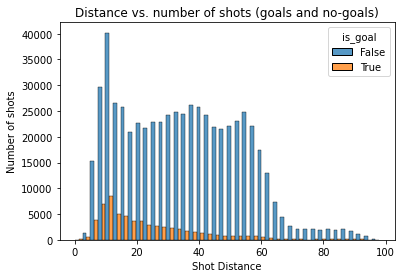

In [154]:
ax = sns.histplot( data, x = "dist_goal", hue="is_goal", multiple="dodge", legend=True, bins=40)
ax.set(xlabel='Shot Distance', ylabel='Number of shots')
ax.set(title='Distance vs. number of shots (goals and no-goals)')
ax.get_figure().savefig("m2_q2_1_dist_to_goal.png")

A histogram of shot counts (goals and no-goals separated), binned by angle

In [155]:
data2 = df[["angle_goal", "is_goal"]].dropna()

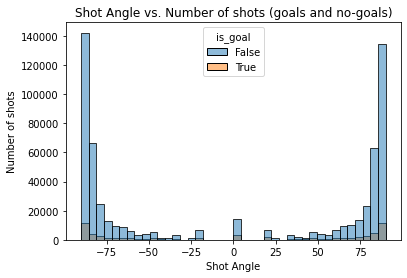

In [156]:
ax = sns.histplot( data2, x = "angle_goal", hue="is_goal",hue_order = ['True', 'False'], bins=40)
ax.set(xlabel='Shot Angle', ylabel='Number of shots')
ax.set(title='Shot Angle vs. Number of shots (goals and no-goals)')
ax.get_figure().savefig("m2_q2_1_angle_to_goal.png")

A 2D histogram where one axis is the distance and the other is the angle. You do not need to separate goals and no-goals.

In [157]:
data3 = df[["dist_goal", "angle_goal", "is_goal"]]

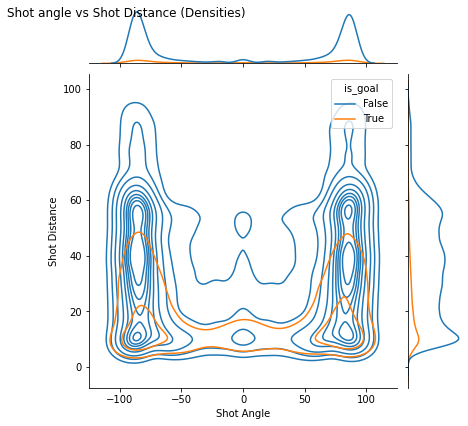

In [162]:
ax = sns.jointplot( data = data3, x = "angle_goal", y = "dist_goal", dropna=True, hue="is_goal", kind="kde")
ax.set_axis_labels( xlabel='Shot Angle', ylabel='Shot Distance')
ax.fig.suptitle(t='Shot angle vs Shot Distance (Densities)',x=0.2)
ax.savefig("m2_q2_1_joint_ang_to_dist_kde.png")

# Relate the goal rate, i.e. #goals / (#no_goals + #goals), to the distance,

In [164]:
data4 = data3[ data3["is_goal"] == 'True' ]

In [165]:
data3 = data3.dropna()
maxDist = int(data3["dist_goal"].max())
bins = list(range(0, maxDist+20, 20))
groups = data3.groupby( [ 'is_goal',  pd.cut( data3["dist_goal"], bins )] )
result = groups.size().unstack().T

In [166]:
result["goalRate"] = result.apply( lambda x : x['True'] / (x.sum() + 1e-8), axis = 1, result_type='expand')
result.reset_index(inplace=True)

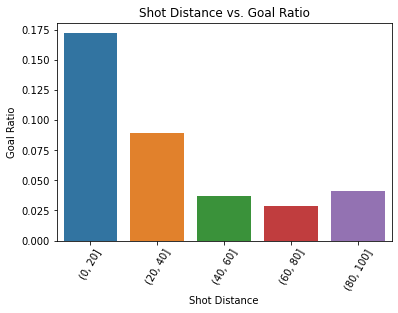

In [167]:
plt.xticks(rotation=60)
ax = sns.barplot( x="dist_goal", y = "goalRate" , data = result)
ax.set(xlabel='Shot Distance', ylabel='Goal Ratio')
ax.set(title='Shot Distance vs. Goal Ratio')
ax.get_figure().savefig("m2_q2_2_shot_dist_goal_ratio.png")

# Relate the goal rate, i.e. #goals / (#no_goals + #goals), to the angle of the shot.

In [168]:
data3 = data3.dropna()
minAng = int(data3["angle_goal"].min())
maxAng = int(data3["angle_goal"].max())

bins = list(range(minAng, maxAng + 20, 20))
groups = data3.groupby( [ 'is_goal',  pd.cut( data3["angle_goal"], bins )] )
result = groups.size().unstack().T

In [169]:
result["AngleGoalRate"] = result.apply( lambda x : x['True'] / (x.sum() + 1e-8), axis = 1, result_type='expand')
result.reset_index(inplace=True)

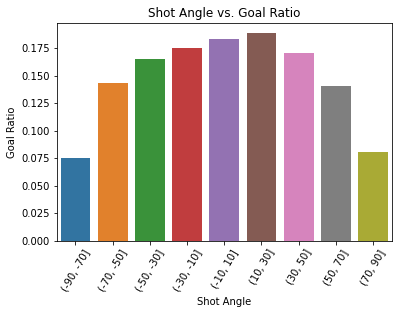

In [170]:
plt.xticks(rotation=60)
ax = sns.barplot( x="angle_goal", y = "AngleGoalRate" , data = result)
ax.set(xlabel='Shot Angle', ylabel='Goal Ratio')
ax.set(title='Shot Angle vs. Goal Ratio')
ax.get_figure().savefig("m2_q2_2_shot_angle_goal_ratio.png")

# create another histogram, this time of goals only, binned by distance, and separate empty net and non-empty net events

In [173]:
data4 = df.loc[ df["is_goal"] == 'True', ["dist_goal", "empty_net"] ].reset_index()

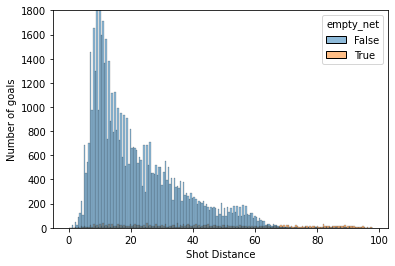

In [174]:
ax = sns.histplot( data4, x = "dist_goal", hue="empty_net", bins=200)
ax.set(xlabel='Shot Distance', ylabel='Number of goals')
ax.set(ylim=(0, 1800))
ax.get_figure().savefig("m2_q2_3_dist_to_emptynet_False.png")

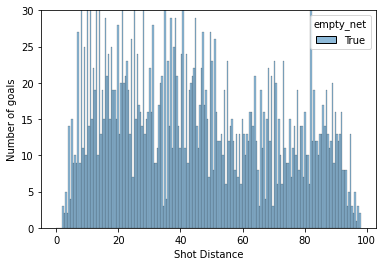

In [176]:
ax = sns.histplot( data4, x = "dist_goal", hue="empty_net", hue_order = ['True'], bins=200)
ax.set(xlabel='Shot Distance', ylabel='Number of goals')
ax.set(ylim=(0, 30))
ax.get_figure().savefig("m2_q2_3_dist_to_emptynet_True.png")